<a href="https://colab.research.google.com/github/gibsonx/CE888/blob/master/Assignment/assignment_2_Distilbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
!pip install -U tensorflow tensorflow_datasets tensorflow_text zhon bert-for-tf2 sentencepiece focal-loss transformers tfa-nightly
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
!git clone https://github.com/cardiffnlp/tweeteval.git

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.7/dist-packages (2.4.1)
Requirement already up-to-date: tensorflow_datasets in /usr/local/lib/python3.7/dist-packages (4.2.0)
Requirement already up-to-date: tensorflow_text in /usr/local/lib/python3.7/dist-packages (2.4.3)
Requirement already up-to-date: zhon in /usr/local/lib/python3.7/dist-packages (1.1.5)
Requirement already up-to-date: bert-for-tf2 in /usr/local/lib/python3.7/dist-packages (0.14.9)
Requirement already up-to-date: sentencepiece in /usr/local/lib/python3.7/dist-packages (0.1.95)
Requirement already up-to-date: focal-loss in /usr/local/lib/python3.7/dist-packages (0.0.6)
Requirement already up-to-date: transformers in /usr/local/lib/python3.7/dist-packages (4.5.0)
Requirement already up-to-date: tfa-nightly in /usr/local/lib/python3.7/dist-packages (0.13.0.dev20210402092435)
fatal: destination path 'tweeteval' already exists and is not an empty directory.


In [37]:
from google.colab import output
from google.colab import drive
import tensorflow_addons as tfa
import os,pathlib,re,nltk,pickle,string
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.stem import WordNetLemmatizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_text as text
from tensorflow.keras import Input, layers, losses, preprocessing, utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.layers.core import Dense
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
# ML Libraries
from sklearn.metrics import accuracy_score,confusion_matrix
from zhon import hanzi 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import csv
import tokenization
from focal_loss import BinaryFocalLoss

from transformers import TFDistilBertModel,DistilBertTokenizer
try:
    %tensorflow_version 2.x
except Exception:
    pass
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Num GPUs Available:  1


In [38]:
# drive.mount('/content/drive/')
base_dir = '/content/tweeteval/datasets/'
hate_dir = base_dir + "hate"
irony_dir = base_dir + "irony"
offensive_dir = base_dir + "offensive"

In [39]:
stop_words = stopwords.words('english')
new_words=['im']
for i in new_words:
  stop_words.append(i) 

def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', string)

def preprocess_tweet_text(tweet):
    tweet = tweet.lower()
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#','', tweet)
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    tweet = tweet.translate(str.maketrans('', '', hanzi.punctuation))
    tweet = remove_emoji(tweet)
    tweet_tokens = word_tokenize(tweet)
    # Remove stopwords
    filtered_words = [w for w in tweet_tokens]
    return " ".join(filtered_words)

def readfile(text):
  pd_list = []
  with open(text,'r') as f:
    for tweet in f.read().splitlines():
      tweet = preprocess_tweet_text(tweet)
      pd_list.append(tweet)   
  return pd_list
 
def readfile_label(text):
  pd_list = []
  with open(text,'r') as f:
    for tweet in f.read().splitlines():
      pd_list.append(int(tweet))  
  return pd_list

In [40]:
#Pre-process csv and merge into a Dataframe
#Hate DataFrame Data 
hate_dict_train = {'text': readfile(os.path.join(hate_dir,"train_text.txt")),'label': readfile_label(os.path.join(hate_dir,"train_labels.txt"))}
hate_dict_val = {'text': readfile(os.path.join(hate_dir,"val_text.txt")),'label': readfile_label(os.path.join(hate_dir,"val_labels.txt"))}
hate_dict_test = {'text': readfile(os.path.join(hate_dir,"test_text.txt")),'label': readfile_label(os.path.join(hate_dir,"test_labels.txt"))}
hate_train_df = pd.DataFrame(hate_dict_train)
hate_val_df = pd.DataFrame(hate_dict_val)
hate_test_df = pd.DataFrame(hate_dict_test)
hate_frames = [hate_train_df, hate_val_df, hate_test_df]
df_hate = pd.concat(hate_frames)
not_hate = df_hate[df_hate['label'] == 0]
hate = df_hate[df_hate['label'] == 1]

#Irony DataFrame
irony_dict_train = {'text': readfile(os.path.join(irony_dir,"train_text.txt")),'label': readfile_label(os.path.join(irony_dir,"train_labels.txt"))}
irony_dict_val = {'text': readfile(os.path.join(irony_dir,"val_text.txt")),'label': readfile_label(os.path.join(irony_dir,"val_labels.txt"))}
irony_dict_test = {'text': readfile(os.path.join(irony_dir,"test_text.txt")),'label': readfile_label(os.path.join(irony_dir,"test_labels.txt"))}
irony_train_df = pd.DataFrame(irony_dict_train)
irony_val_df = pd.DataFrame(irony_dict_val)
irony_test_df = pd.DataFrame(irony_dict_test)
irony_frames = [irony_train_df,irony_val_df,irony_test_df]
df_irony = pd.concat(irony_frames)
not_irony  = df_irony[df_irony['label'] == 0]
irony  = df_irony[df_irony['label'] == 1]

#Offensive DataFrame
offensive_dict_train = {'text': readfile(os.path.join(offensive_dir,"train_text.txt")),'label': readfile_label(os.path.join(offensive_dir,"train_labels.txt"))}
offensive_dict_val = {'text': readfile(os.path.join(offensive_dir,"val_text.txt")),'label': readfile_label(os.path.join(offensive_dir,"val_labels.txt"))}
offensive_dict_test = {'text': readfile(os.path.join(offensive_dir,"test_text.txt")),'label': readfile_label(os.path.join(offensive_dir,"test_labels.txt"))}
offensive_train_df = pd.DataFrame(offensive_dict_train)
offensive_val_df = pd.DataFrame(offensive_dict_val)
offensive_test_df = pd.DataFrame(offensive_dict_test)
offensive_frames = [offensive_train_df,offensive_val_df,offensive_test_df]
df_offensive = pd.concat(offensive_frames)
not_offensive  = df_offensive[df_offensive['label'] == 0]
offensive  = df_offensive[df_offensive['label'] == 1]

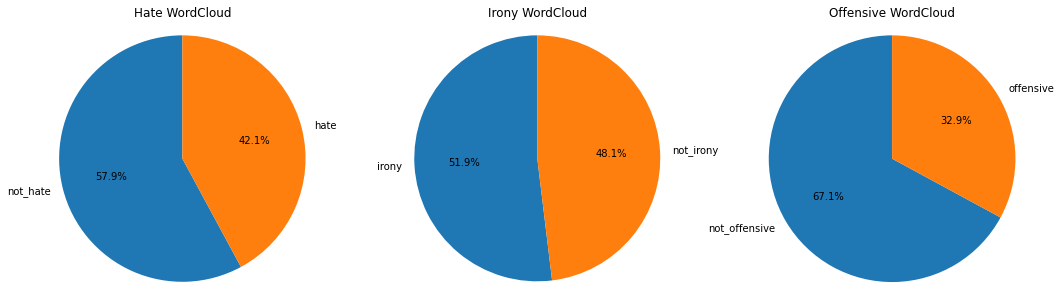

In [41]:
fig, axs = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(18)

nh_p = len(not_hate) / len(df_hate)
h_p = len(hate) / len(df_hate)
#Hate
h_sizes = [nh_p,h_p]
h_labels = 'not_hate', 'hate'
axs[0].axis('off')
axs[0].set_title("Hate WordCloud")
axs[0].pie(h_sizes, labels=h_labels, autopct='%1.1f%%',startangle=90)
axs[0].axis('equal')

#Irony
ni_p = len(not_irony) / len(df_irony)
i_p = len(irony) / len(df_irony)
i_sizes = [ni_p,i_p]
i_labels = 'irony', 'not_irony'
axs[1].axis('off')
axs[1].set_title("Irony WordCloud")
axs[1].pie(i_sizes, labels=i_labels, autopct='%1.1f%%',startangle=90)
axs[1].axis('equal')

no_p = len(not_offensive) / len(df_offensive)
o_p = len(offensive) / len(df_offensive)
#Offensive
h_sizes = [no_p,o_p]
h_labels = 'not_offensive', 'offensive'
axs[2].axis('off')
axs[2].set_title("Offensive WordCloud")
axs[2].pie(h_sizes, labels=h_labels, autopct='%1.1f%%',startangle=90)
axs[2].axis('equal')

plt.show()

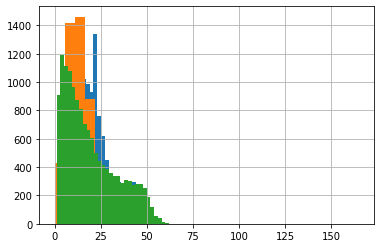

In [42]:
#The length of sentences after tokenization
seq_len = [len(i.split()) for i in df_hate['text']]
pd.Series(seq_len).hist(bins = 30)
seq_len = [len(i.split()) for i in df_irony['text']]
pd.Series(seq_len).hist(bins = 30)
seq_len = [len(i.split()) for i in df_offensive['text']]
pd.Series(seq_len).hist(bins = 30)

In [43]:
#Generate Data for WordCloud
#Hate wordcloud
not_hate_text = " ".join(preprocess_tweet_text(review) for review in not_hate["text"])
hate_text = " ".join(preprocess_tweet_text(review) for review in hate["text"])
wordcloud_not_hate = WordCloud(max_words=100,background_color="grey").generate(not_hate_text)
wordcloud_hate = WordCloud(max_words=100,background_color="grey").generate(hate_text)
#Irony wordcloud
not_irony_text = " ".join(preprocess_tweet_text(review) for review in not_irony["text"])
irony_text = " ".join(preprocess_tweet_text(review) for review in irony["text"])
wordcloud_not_irony = WordCloud().generate(not_irony_text)
wordcloud_irony = WordCloud().generate(irony_text)
#Offensive wordcloud
not_offensive_text = " ".join(preprocess_tweet_text(review) for review in not_offensive["text"])
offensive_text = " ".join(preprocess_tweet_text(review) for review in offensive["text"])
wordcloud_not_offensive = WordCloud(max_words=100,background_color="white").generate(not_offensive_text)
wordcloud_offensive = WordCloud(max_words=100,background_color="white").generate(offensive_text)

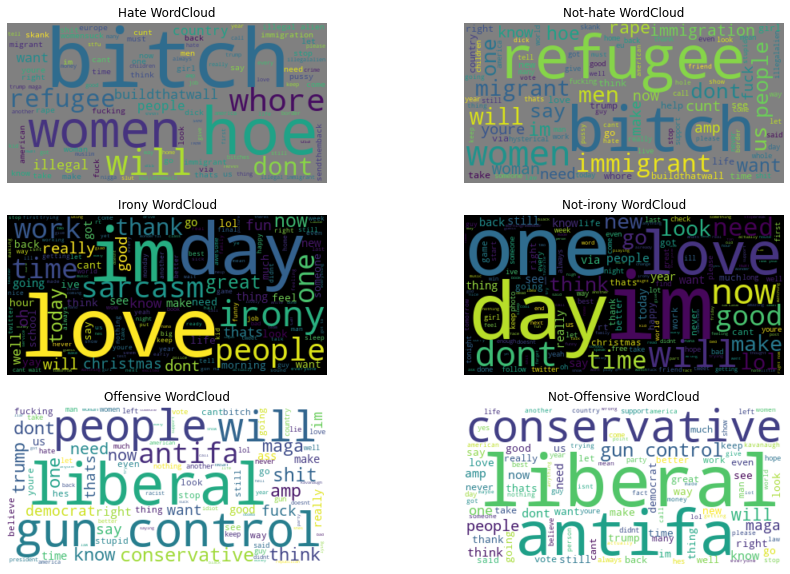

In [44]:
#Wordcloud Plot
fig, axs = plt.subplots(3,2)
fig.set_figheight(10)
fig.set_figwidth(15)
axs[0,0].axis('off')
axs[0,0].set_title("Hate WordCloud")
axs[0,0].imshow(wordcloud_hate, interpolation='bilinear')
axs[0,1].set_title("Not-hate WordCloud")
axs[0,1].imshow(wordcloud_not_hate, interpolation='bilinear')
axs[0,1].axis('off')
axs[1,0].set_title("Irony WordCloud")
axs[1,0].imshow(wordcloud_irony, interpolation='bilinear')
axs[1,0].axis('off')
axs[1,1].set_title("Not-irony WordCloud")
axs[1,1].imshow(wordcloud_not_irony, interpolation='bilinear')
axs[1,1].axis('off')
axs[2,0].set_title("Offensive WordCloud")
axs[2,0].imshow(wordcloud_offensive, interpolation='bilinear')
axs[2,0].axis('off')
axs[2,1].set_title("Not-Offensive WordCloud")
axs[2,1].imshow(wordcloud_not_offensive, interpolation='bilinear')
axs[2,1].axis('off')

plt.show()
plt.close()

In [45]:
def bert_encode(texts, tokenizer, max_len=512):
  all_tokens = []
  all_masks = []
  all_segments = []
  for text in texts:
      text = tokenizer.tokenize(text)
      text = text[:max_len-2]
      input_sequence = ["[CLS]"] + text + ["[SEP]"]
      pad_len = max_len - len(input_sequence)
      tokens = tokenizer.convert_tokens_to_ids(input_sequence)
      tokens += [0] * pad_len
      pad_masks = [1] * len(input_sequence) + [0] * pad_len
      segment_ids = [0] * max_len
      all_tokens.append(tokens)
      all_masks.append(pad_masks)
      all_segments.append(segment_ids)
  return np.array(all_tokens), np.array(all_masks)

def bert_encode(tweets, tokenizer, max_len=512):
    """ Gets tensors from text using the tokenizer provided"""
    inps = [tokenizer.encode_plus(t, max_length=max_len, pad_to_max_length=True, add_special_tokens=True) for t in tweets]
    inp_tok = np.array([a['input_ids'] for a in inps])
    ids = np.array([a['attention_mask'] for a in inps])
    # segments = np.array([a['token_type_ids'] for a in inps])
    return inp_tok, ids


In [46]:
#Create Bert Model
def build_model(bert_layer, max_len=512):
    ids = Input(shape=(max_len,), dtype=tf.int32, name="ids")
    mask = Input(shape=(max_len,), dtype=tf.int32, name="mask")
    seg = Input(shape=(max_len,), dtype=tf.int32, name="seg")
    doc_encoding = bert_layer(input_ids=ids, attention_mask=mask)[0][:,0,:]
    out = Dense(1, activation='sigmoid')(doc_encoding)
    model = Model(inputs=[ids, mask], outputs=out)
    model.compile(Adam(lr=1e-5), loss=BinaryFocalLoss(gamma=2), metrics=[tfa.metrics.F1Score(num_classes=2, average="micro"),'accuracy'])
    return model

In [47]:
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [65]:
from transformers import TFDistilBertModel,DistilBertTokenizer,DistilBertConfig
DistilBertConfig = DistilBertConfig.from_pretrained('distilbert-base-uncased', output_hidden_states=True, output_attentions=True)
dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased',config=DistilBertConfig)
dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_transform', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [49]:
#Encoding text for hate datasets
ha_train_input = bert_encode(hate_train_df.text, dbert_tokenizer, max_len=160)
ha_val_input = bert_encode(hate_val_df.text, dbert_tokenizer, max_len=160)
ha_test_input = bert_encode(hate_test_df.text, dbert_tokenizer, max_len=160)
ha_train_input

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


(array([[ 101, 3835, 2047, ...,    0,    0,    0],
        [ 101, 1037, 2450, ...,    0,    0,    0],
        [ 101, 2613, 2831, ...,    0,    0,    0],
        ...,
        [ 101, 7743, 2017, ...,    0,    0,    0],
        [ 101, 2900, 2003, ...,    0,    0,    0],
        [ 101, 7632, 2190, ...,    0,    0,    0]]),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]))

In [50]:
model = build_model(dbert_model, max_len=160)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ids (InputLayer)                [(None, 160)]        0                                            
__________________________________________________________________________________________________
mask (InputLayer)               [(None, 160)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB TFBaseModelOutput(la 66362880    ids[0][0]                        
                                                                 mask[0][0]                       
__________________________________________________________________________________________________
tf.__operators__.getitem_4 (Sli (None, 768)          0           tf_distil_bert_model[0][0] 

In [51]:
#Training Hate model
def warmup(epoch, lr):
    """Used for increasing the learning rate slowly, this tends to achieve better convergence.
    However, as we are finetuning for few epoch it's not crucial.
    """
    return max(lr +1e-6, 2e-5)
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4, min_delta=0.001, restore_best_weights=True),
    tf.keras.callbacks.LearningRateScheduler(warmup, verbose=0),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=1e-6, patience=2, verbose=0, mode='auto', min_delta=0.001, cooldown=0, min_lr=1e-6)
]
train_history = model.fit(
    ha_train_input, hate_train_df.label,
    validation_data=(ha_val_input, hate_val_df.label),
    epochs=20,
    callbacks=callbacks,
    batch_size=16
)

Epoch 1/20
 20/563 [>.............................] - ETA: 1:34 - loss: 0.2151 - f1_score: 0.5878 - accuracy: 0.4631

KeyboardInterrupt: ignored

In [ ]:
# model.evaluate(test_input, y_test,batch_size=200)
test_pred = model.predict(ha_test_input)
y_pred = [i[0] for i in test_pred.round().astype(int)]
cm = confusion_matrix(hate_test_df.label,y_pred)

In [ ]:
plot_confusion_matrix(cm, normalize=False,target_names=['Not_hate', 'Hate'],title="Confusion Matrix for Hate")

In [ ]:
#Encoding text for irony datasets
ir_train_input = bert_encode(irony_train_df.text, dbert_tokenizer, max_len=160)
ir_val_input = bert_encode(irony_val_df.text, dbert_tokenizer, max_len=160)
ir_test_input = bert_encode(irony_test_df.text, dbert_tokenizer, max_len=160)

In [52]:
from keras import backend as K
K.clear_session()
del model
model = build_model(dbert_model, max_len=160)

train_history = model.fit(
    ir_train_input, irony_train_df.label,
    validation_data=(ir_val_input, irony_val_df.label),
    epochs=3,
    callbacks=callbacks,
    batch_size=16
)

Epoch 1/3
179/179 [==============================] - 46s 206ms/step - loss: 0.1861 - f1_score: 0.6831 - accuracy: 0.5350 - val_loss: 0.1559 - val_f1_score: 0.6464 - val_accuracy: 0.6503
Epoch 2/3
179/179 [==============================] - 35s 196ms/step - loss: 0.1424 - f1_score: 0.6667 - accuracy: 0.7053 - val_loss: 0.1890 - val_f1_score: 0.6464 - val_accuracy: 0.6272
Epoch 3/3
109/179 [=================>............] - ETA: 12s - loss: 0.0829 - f1_score: 0.6573 - accuracy: 0.8772

KeyboardInterrupt: ignored

In [ ]:
test_pred = model.predict(ir_test_input)
y_pred = [i[0] for i in test_pred.round().astype(int)]
cm = confusion_matrix(irony_test_df.label,y_pred)

In [ ]:
plot_confusion_matrix(cm, normalize=False,target_names=['Not_irony', 'irony'],title="Confusion Matrix for Irony")

In [53]:
model.evaluate(ir_test_input,irony_test_df['label'], verbose=True)

25/25 [==============================] - 3s 105ms/step - loss: 0.2221 - f1_score: 0.5680 - accuracy: 0.6671


[0.2220616489648819, 0.5680364966392517, 0.6670918464660645]

In [56]:
#Encoding text for offensive datasets
of_train_input = bert_encode(offensive_train_df.text, dbert_tokenizer, max_len=160)
of_val_input = bert_encode(offensive_val_df.text, dbert_tokenizer, max_len=160)
of_test_input = bert_encode(offensive_test_df.text, dbert_tokenizer, max_len=160)
of_test_input

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


(array([[  101, 21307, 20806, ...,     0,     0,     0],
        [  101,  1045,  2288, ...,     0,     0,     0],
        [  101,  2065,  2017, ...,     0,     0,     0],
        ...,
        [  101, 11992,  2123, ...,     0,     0,     0],
        [  101,  3424,  7011, ...,     0,     0,     0],
        [  101,  7081,  2017, ...,     0,     0,     0]]),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]))

In [66]:
del model_of
model_of = build_model(dbert_model, max_len=160)

train_history = model_of.fit(
    of_train_input, offensive_train_df.label,
    validation_data=(of_val_input, offensive_val_df.label),
    epochs=5,
    callbacks=callbacks,
    batch_size=16
)

Epoch 1/5


KeyboardInterrupt: ignored

In [58]:
test_pred = model_of.predict(of_test_input)
y_pred = [i[0] for i in test_pred.round().astype(int)]
cm = confusion_matrix(offensive_test_df.label,y_pred)

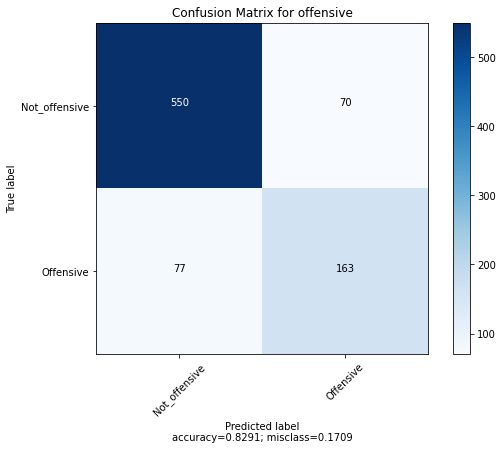

In [59]:
plot_confusion_matrix(cm, normalize=False,target_names=['Not_offensive', 'Offensive'],title="Confusion Matrix for offensive")

In [60]:
model_of.evaluate(of_test_input,offensive_test_df['label'], verbose=True)

27/27 [==============================] - 3s 107ms/step - loss: 0.2963 - f1_score: 0.4364 - accuracy: 0.8291


[0.2963157594203949, 0.43636366724967957, 0.8290697932243347]